In [1]:
import pandas as pd
from datasets import load_dataset
from matplotlib import pyplot as plt
from Huggingface.noteboooks.utils import FakeNewsExplainer
%matplotlib inline

2022-10-30 00:14:09.358883: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


This project is written and tested in Python 3.7.13


In [2]:
model = {
        'NAME': 'GonzaloA/distilroberta-base-finetuned-fakeNews',
        'LABEL_MAPPINGS': {'LABEL_0': 'Fake', 'LABEL_1': 'Real', 0: 'Fake', 1:  'Real'},
        'DATASET': 'GonzaloA/fake_news',
        'EXTERNAL_LINKS': [],
    }
fake_news_explainer = FakeNewsExplainer(model)

Using custom data configuration GonzaloA--fake_news-2fa3f217e39cb456
Reusing dataset parquet (/home/sersery/.cache/huggingface/datasets/GonzaloA___parquet/GonzaloA--fake_news-2fa3f217e39cb456/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

Using device: cuda
Getting the indexes: [24254 10927 24264  2836  6697  2999  5316 17456 13202 16440 11117 15108
  5151  3832 17854 19541  6011 19808  3711 15177 20308  6402 20342 13771
   969 13649 20536  8663  7172 18156  6432 17064 14107  9723  3736 15815
  1916 18531 24263 18438 15201 21286 11560 16239 22267 20904  5867  1615
   352 12823  8092 23485  7378  3122 11509  1058 19704  1638 19092 20812
 10893 18485 19245 18716 10206  6864   628  6583 16995 18021  8904 15860
  8738 22898  3200 17595  6740 15749 16797  1785 10283  1245 18543 18145
 14754 20667  9213 10298  3838  6140  7154 18475   295 13964  7415 23852
  9935  1445  4818 17567 16148 19747  2389  7725 15498 12202 11213 13578
  7986  3369 20602 10034 20072   247  4204  8944 20055  6204  9658 15085
 13073 14346 20356 22386 13668   540  9953 11672  1798  3084  8591 22120
  6995   724  9674 15870  9850 16429 21360 18276   512 21892 12057  1192
   330   641  1552 13027 22084 16153 22693 16840  8256  2401 15342 15762
 13634 1494

2022-10-30 00:14:26.690619: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 00:14:26.691836: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 00:14:26.691984: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-30 00:14:26.693221: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compi

In [3]:
train_dataset = fake_news_explainer.dataset.get('train').to_pandas()
val_dataset = fake_news_explainer.dataset.get('validation').to_pandas()
test_dataset = fake_news_explainer.dataset.get('test').to_pandas()

In [16]:
from matplotlib.colors import CSS4_COLORS
def plot_label_distribution(ax, ds, fake_color, real_color, label):
    fake_news = ds[ds.label == 0]['label'].apply(lambda x: 'Fake')
    print(f'len fake news {len(fake_news)}')
    real_news = ds[ds.label == 1]['label'].apply(lambda x: 'Real')
    print(f'len real news {len(real_news)}')
    height_offsets = {'fake': 0, 'real': 0}
    for i, rect in enumerate(ax.patches):
        if i%2 == 0:
            height_offsets['fake'] += rect.get_height()
        else:
            height_offsets['real'] += rect.get_height()
    bar = ax.bar(x=['Fake', 'Real'], height=[len(fake_news), len(real_news)], bottom=[height_offsets['fake'], height_offsets['real']], color=[fake_color, real_color], label=label)
    ax.bar_label(bar, label_type='center', fontsize=20, color='black')


def plot_dataset_label_distribution_by_split(train_ds, val_ds, test_ds):
    fig, ax = plt.subplots(figsize=(12, 8))
    plot_label_distribution(ax, train_ds, fake_color=CSS4_COLORS.get('dodgerblue'), real_color=CSS4_COLORS.get('dodgerblue'), label='train')
    plot_label_distribution(ax, val_ds, fake_color=CSS4_COLORS.get('darkgreen'), real_color=CSS4_COLORS.get('darkgreen'), label='validation')
    plot_label_distribution(ax, test_ds, fake_color=CSS4_COLORS.get('crimson'), real_color=CSS4_COLORS.get('crimson'), label='test')


    print(f'Total len: {len(train_ds) + len(val_ds) + len(test_ds)}')

    ax.set_xlabel('News Type')
    ax.set_ylabel('Count')
    ax.legend()
    # ax.legend(handles=[btrain, bval, btest])
    plt.savefig(f'plot_images/DatasetDistrByLabelAndSplit.pdf', bbox_inches='tight')
    plt.show()

len fake news 11158
len real news 13195
len fake news 3723
len real news 4394
len fake news 3782
len real news 4335
Total len: 40587


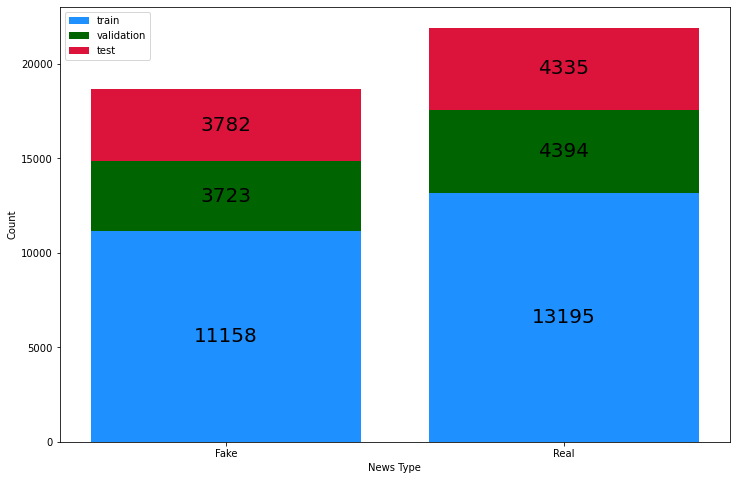

In [17]:
plot_dataset_label_distribution_by_split(train_dataset, val_dataset, test_dataset)

## Now we visualize the most commonly used words as a WordCloud

In [18]:
from wordcloud import WordCloud

In [19]:
# we need to get the most frequent 500 tokens in the train dataset
def get_most_frequent_n_tokens(df: pd.DataFrame, tokenizer, n=500):
    freq_map = {}
    special_tokens = list(tokenizer.special_tokens_map.values())
    for r in df['text']:
        tokenized = tokenizer(r)['input_ids']
        for token in tokenized:
            if token not in special_tokens:
                if token in freq_map.keys():
                    freq_map[token] += 1
                else:
                    freq_map[token] = 1
    freq_df = pd.DataFrame({'tokens': freq_map.keys(), 'frequency': freq_map.values()})
    freq_df = freq_df.sort_values(by='frequency', ascending=False)
    freq_df['tokens'] = freq_df['tokens'].apply(lambda x: tokenizer.decode(x))

    return freq_df[:n]

### Real News WordCloud

In [20]:
real_news_word_frequency_df = get_most_frequent_n_tokens(train_dataset[train_dataset.label == 1], fake_news_explainer.tokenizer)
real_news_word_frequency_df

Token indices sequence length is longer than the specified maximum sequence length for this model (559 > 512). Running this sequence through the model will result in indexing errors


,tokens,frequency
15,the,264867
47,.,257120
32,",",245086
36,to,151567
43,of,128187
...,...,...
576,denied,1402
1097,Tillerson,1399
1628,General,1399
318,become,1398


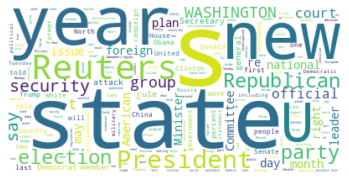

In [21]:
wordcloud = WordCloud(background_color='white').generate('\n'.join(real_news_word_frequency_df['tokens'].values.tolist()))
plt.axis('off')
wordcloud.to_file('plot_images/DatasetRealFrequentTokensWordcloud.pdf')
# plt.savefig(, bbox_inches='tight')
plt.imshow(wordcloud, interpolation='bilinear')

### Fake News WordCloud

In [22]:
fake_news_word_frequency_df = get_most_frequent_n_tokens(train_dataset[train_dataset.label == 0], fake_news_explainer.tokenizer)

### Visualization of most frequent 500 words

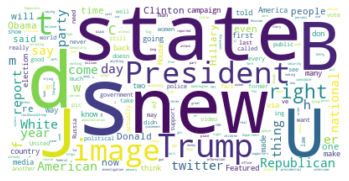

In [23]:
wordcloud = WordCloud(background_color='white').generate('\n'.join(fake_news_word_frequency_df['tokens'].values.tolist()))
plt.axis('off')
wordcloud.to_file('plot_images/DatasetFakeFrequentTokensWordcloud.pdf')
plt.imshow(wordcloud, interpolation='bilinear')

## Now investigate some words in the datasets

### We first start with "(Reuters)" in train_dataset with true labels

In [12]:
train_dataset_real_news = train_dataset[train_dataset.label == 1]
keyword = '(Reuters)'
rows_with_keyword = []
indexes = []
for row , idx in zip(train_dataset_real_news['text'], train_dataset_real_news.index):
    if keyword in row:
        rows_with_keyword.append(row)
        indexes.append(idx)
print(f'Out of {len(train_dataset_real_news)} samples in train dataset, {len(rows_with_keyword)} ({100 * len(rows_with_keyword) / len(train_dataset_real_news)}%) samples contain {keyword}')


Out of 13195 samples in train dataset, 12658 (95.93027661993179%) samples contain (Reuters)


In [13]:
import numpy as np
common_tokens = np.intersect1d(real_news_word_frequency_df['tokens'], fake_news_word_frequency_df['tokens'])
len(common_tokens)

315

In [15]:
fake_news_explainer.model.config

RobertaConfig {
  "_name_or_path": "GonzaloA/distilroberta-base-finetuned-fakeNews",
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.19.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}